## Still photos classification by scene type

In [65]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

UsageError: Line magic function `%inline.rc` not found.


Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

dataset is download from https://s3-eu-west-1.amazonaws.com/bill2/capture_data/still_photo_resized.zip
aws s3 cp s3://bill2/capture_data/still_photo_resized.zip still_photo_resized.zip
`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [3]:
PATH = "data/ml_spike_2/all_room/"

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## First look at still photos

- training photos are under `train-jpg`
- labels are in `stills_by_scene_type.csv`

In [6]:
os.listdir(PATH)

['tmp',
 'registration.csv',
 'registration copy.csv',
 'images',
 'registration_all_room.csv',
 'models',
 'registration_diff_room.csv',
 'registration_same_room.csv']

In [7]:
len(os.listdir(f'{PATH}images'))

28714

In [8]:
files = os.listdir(f'{PATH}images')[:10]
files

['5a4e1014fc90bc0c339a5518_Bedroom_2-1_Bedroom_2-2_1529452557473_err.png',
 '5a4e211a0e0c460c58d6cea7_Hall_Bedroom_2_1529462732045.2.png',
 '5a817d4f5f1a241d37605eb6_Hall-3_4_1_2_Hall-5_1529504443377.png',
 '5a9d18691424a00c569fe72e_Kitchen-2_Kitchen-3_1_1529464955044.4.png',
 '5a55fc545dd4710c55aab472_Bedroom_3-1_Bedroom_3-2_1529469843354.2.png',
 '5aa0293a2075500c5a75581a_Bathroom-1_Bathroom-2_1529444398703_err.png',
 '5a8c562a5f1a2455eb77326e_Hall_Kitchen_Reception_1529464143598.1.png',
 '5a9e69151424a00c569fe735_Hall-3_1_2_Hall-4_1529501656473.3.png',
 '5aba4a246de8c90c5abb21b8_Hall_Master_Bedroom_1529461237067.3.png',
 '5a539b400e0c460c58d6ceaf_Bedroom_2-2_Bedroom_2-1_1529464458990.png']

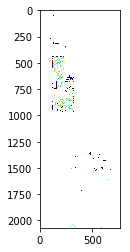

In [13]:
img = plt.imread(f'{PATH}images/{files[random.randint(0,9)]}')
plt.imshow(img);

Here is how the raw data looks like

In [20]:
img.shape

(2070, 768, 4)

## Select pre-trained model

Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). 

In [21]:
arch=resnet34 #     resnet34, - resnext50,     - resnext101

## Load labels from cvs

In [22]:
label_csv = f'{PATH}registration_all_room.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
len(val_idxs)

5742

## Load image from folder with augmentation

In [23]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz,  aug_tfms=transforms_side_on, max_zoom=1.2) #  max random zooming 1.1
    return ImageClassifierData.from_csv(PATH, 'images', label_csv, tfms=tfms,
                     val_idxs=val_idxs)

## Get data, define model ( freezed )

In [24]:
data = get_data(512)
data.classes

['correct', 'wrong']

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

## Find Learning rate

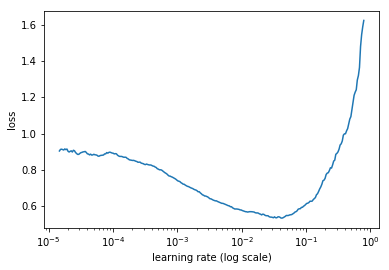

In [61]:
lrf=learn.lr_find()
learn.sched.plot()

## Training

In [62]:

learn.fit(0.01, 20)

epoch      trn_loss   val_loss   accuracy                    
    0      0.348927   0.272234   0.883664  
    1      0.306478   0.229993   0.908568                    
    2      0.269473   0.206849   0.917276                    
    3      0.252376   0.194766   0.923894                    
    4      0.232041   0.18414    0.930686                    
    5      0.216453   0.175069   0.935388                    
    6      0.228376   0.164373   0.937827                    
    7      0.209204   0.167008   0.935214                    
    8      0.18483    0.141023   0.948624                    
    9      0.1806     0.137279   0.954197                    
    10     0.170589   0.127723   0.953849                    
    11     0.158621   0.123275   0.961338                    
    12     0.161871   0.122421   0.956635                    
    13     0.160204   0.136025   0.949321                    
    14     0.141253   0.119592   0.956635                    
    15     0.147295   0.11

[array([0.11413]), 0.9583768722114975]

Initial accuracy is 
- 0.66 after 2 epoches
- 0.71 after 10 epoches
- overfitting after 10 epoches


In [63]:
learn.save("all_room_freeze_res50")

In [26]:
learn.load("all_room_freeze_res34")

In [100]:
learn.sched.plot_loss()

AttributeError: 'NoneType' object has no attribute 'plot_loss'

## Fine-tuning and differential learning rate annealing

In [24]:
learn.unfreeze()

In [25]:
lr=np.array([0.00001,0.0001,0.005])

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.499763   0.302212   0.88558   
 31%|███       | 112/359 [05:16<11:37,  2.83s/it, loss=0.481]

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_lr()

### test time augmentation

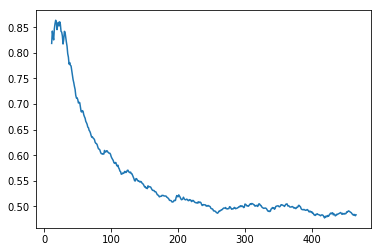

In [29]:
learn.sched.plot_loss()

In [27]:
log_preds,y = learn.TTA()


In [28]:
probs = np.mean(np.exp(log_preds),0)


In [29]:
accuracy_np(probs, y)

0.9366074538488331

In [30]:
avg_log_preds = np.log(probs)

In [31]:
avg_log_preds.shape

(5742, 2)

In [35]:
imr =ImageModelResults(data.val_ds, avg_log_preds)

In [36]:
data.classes

['correct', 'wrong']

'images/5a9fceeab4791d0c6b019aac_Master_Ensuite-1_Master_bedroom_1529460801868_err.png'

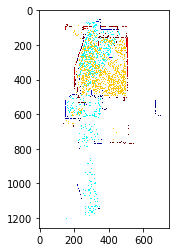

In [68]:

img = plt.imread(f'{PATH}{data.val_ds.fnames[3451]}')
plt.imshow(img);
data.val_ds.fnames[3451]

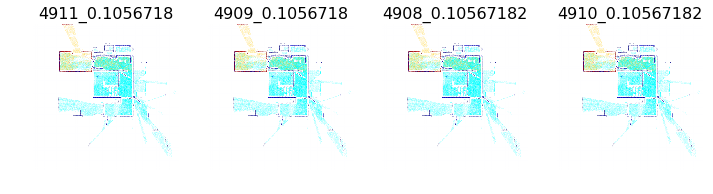

In [50]:
imr.plot_most_incorrect(data.classes.index("correct"))

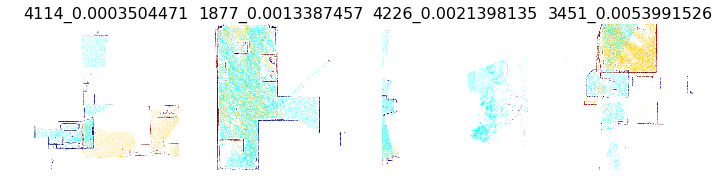

In [51]:
imr.plot_most_incorrect(data.classes.index("wrong"))

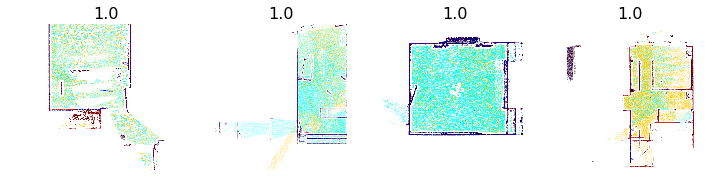

In [74]:
imr.plot_most_correct(data.classes.index("correct"))

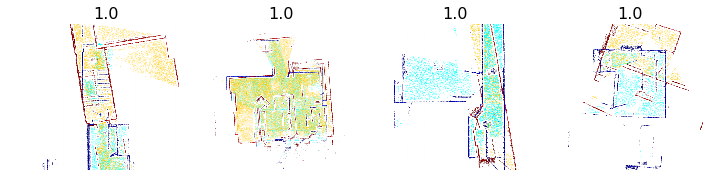

In [75]:
imr.plot_most_correct(data.classes.index("wrong"))

In [76]:
preds = np.argmax(probs, axis=1)

In [77]:
# analysis test

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)


[[2823   15]
 [ 224 2680]]


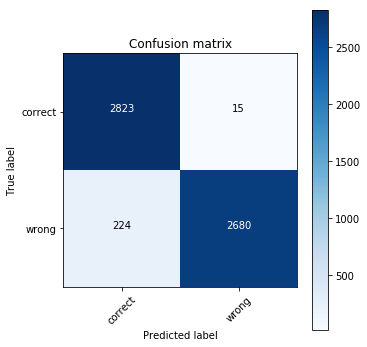

In [79]:
plot_confusion_matrix(cm, data.classes, figsize=(5,5))

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [58]:
# This is the label for a val data
data.val_y

array([10, 18, 21, ..., 26, 15, 10])

In [64]:
len(data.val_y)

2171

In [27]:
len(data.classes)

2

In [28]:
data.classes

['correct', 'wrong']

In [73]:
[data.classes.index('BEDROOM'),
 data.classes.index('LIBRARY'),
]

[3, 19]

In [ ]:
probs = probs[:,1]

In [103]:
len(log_preds)

5

In [102]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
preds

array([[ 196,  444, 1039,  199, 1528, 1998, 1077,  423,  997, 1405,  583, 1801,  549, 1610, 1016, 1350,
        2028,  529,  374,  423,  116,  868,  510,  280, 1181, 1404, 2033,  709,  118,  446,  748, 1933,
        1913,  696,  426,  311],
       [1101,  241, 1039,  571, 1528, 1998, 1496, 1444, 1194, 1405,  752, 1801,  508, 1610,  444,  546,
        2028,  529, 1426, 1848,  425,  868,  510,  280, 1181, 1404, 1182,  709,  118,  464,  748, 1880,
        1913,  696,  426, 1470],
       [ 196,  423, 1366, 2139, 1528, 1998, 1077,  423, 1150, 1405,  717, 1801,  549,  544, 1016,  347,
        2028,  527, 1426,  423,  425,  591,  510,  280,  275,  444, 2033,  709,  118,  464,  748,  653,
        1913,  518,  177, 2013],
       [ 196, 1528,  872,  571, 1528, 1998, 1077,  423,  997, 1404,  717, 1801,  508,  544, 1017, 1302,
        2028, 1563, 1426,  423,  116,  591,  510, 1897, 1842, 1404, 2033,  709,  118,  464,  748,  653,
        1913,  696,  426, 1346],
       [ 196,  423,   66,  569, 1528

In [98]:
probs_bedroom = np.exp(log_preds[:,3])  # pr(BEDROOM)
probs_bedroom

array([[0.00056, 0.00001, 0.00204, 0.50213, 0.00002, 0.00009, 0.00003, 0.00002, 0.0004 , 0.00004, 0.00001,
        0.00002, 0.00005, 0.00001, 0.00001, 0.00253, 0.00039, 0.00033, 0.01641, 0.00002, 0.00001, 0.46189,
        0.0004 , 0.00004, 0.00001, 0.00003, 0.00358, 0.00003, 0.00826, 0.00015, 0.00018, 0.00008, 0.00009,
        0.00003, 0.00004, 0.00008],
       [0.00022, 0.00001, 0.00158, 0.57253, 0.00001, 0.00012, 0.00003, 0.00003, 0.0002 , 0.00001, 0.00001,
        0.00002, 0.00005, 0.00003, 0.00001, 0.00375, 0.00013, 0.00008, 0.00404, 0.00002, 0.00001, 0.40933,
        0.00027, 0.00005, 0.00001, 0.00001, 0.00188, 0.00005, 0.00476, 0.00018, 0.0002 , 0.00015, 0.00006,
        0.00003, 0.00003, 0.00009],
       [0.00036, 0.00001, 0.00104, 0.65397, 0.00001, 0.00005, 0.00002, 0.00002, 0.00023, 0.00002, 0.     ,
        0.00001, 0.00003, 0.00001, 0.00001, 0.00148, 0.00018, 0.00031, 0.00937, 0.00001, 0.00001, 0.32607,
        0.00018, 0.00002, 0.00001, 0.00001, 0.00214, 0.00003, 0.00398, 0

In [99]:
probs_library = np.exp(log_preds[:,19])  # pr(BEDROOM)
probs_library

array([[0.00055, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.99923,
        0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.00001, 0.     , 0.     , 0.     ,
        0.     , 0.00013, 0.00001, 0.     , 0.00001, 0.     , 0.     , 0.     , 0.00001, 0.00002, 0.     ,
        0.     , 0.     , 0.     ],
       [0.00209, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.99726,
        0.00001, 0.     , 0.     , 0.00001, 0.     , 0.     , 0.     , 0.00011, 0.00001, 0.     , 0.00001,
        0.     , 0.00032, 0.00006, 0.     , 0.00001, 0.     , 0.     , 0.     , 0.00005, 0.00003, 0.     ,
        0.00001, 0.00001, 0.     ],
       [0.00441, 0.     , 0.     , 0.00001, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.99504,
        0.     , 0.     , 0.     , 0.00002, 0.     , 0.     , 0.     , 0.00005, 0.     , 0.     , 0.00001,
        0.     , 0.00017, 0.00004, 0.     , 0.00001, 0.     , 0.     , 0

In [86]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [87]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [88]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [89]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [90]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  


ValueError: a must be non-empty

Incorrectly classified


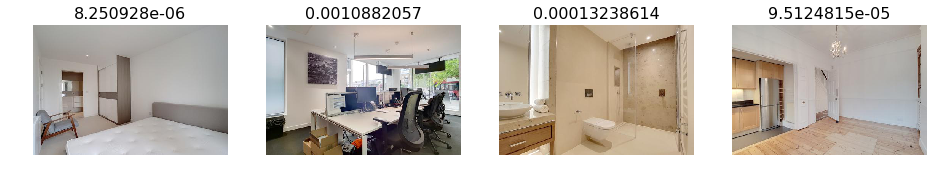

In [43]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [44]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct


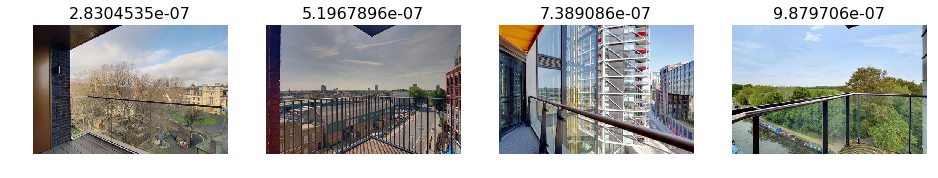

In [45]:
plot_val_with_title(most_by_correct(0, True), "Most correct")

In [46]:
plot_val_with_title(most_by_correct(1, True), "Most correct")

Most correct


<Figure size 1152x576 with 0 Axes>

Most incorrect cats


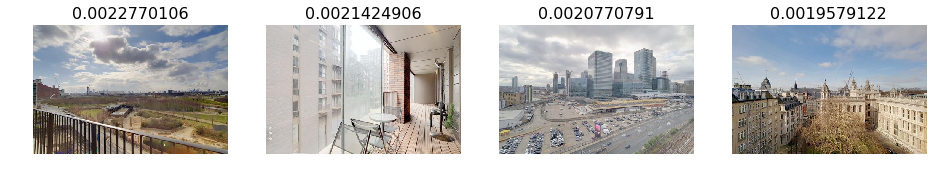

In [47]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


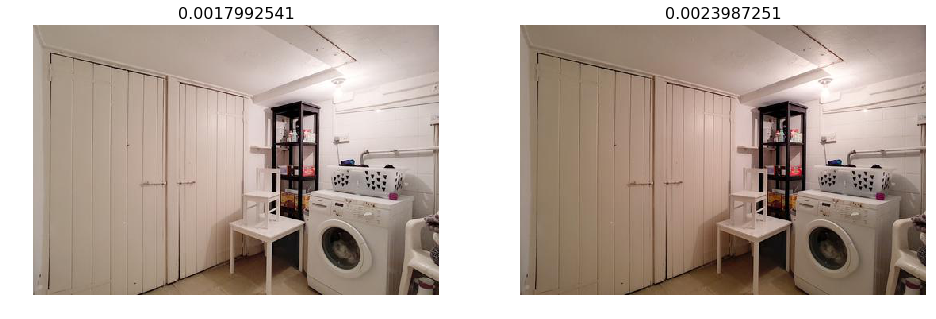

In [48]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


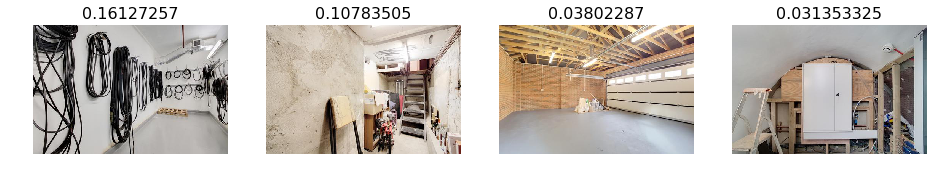

In [49]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Analyzing results

### Confusion matrix 

In [34]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

ValueError: Found input variables with inconsistent numbers of samples: [2171, 10]

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[115   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0 123 ...   0   0   6]
 ...
 [  0   0   0 ...   3   0   0]
 [  3   0   0 ...   0   0   0]
 [  0   0   3 ...   0   0  16]]


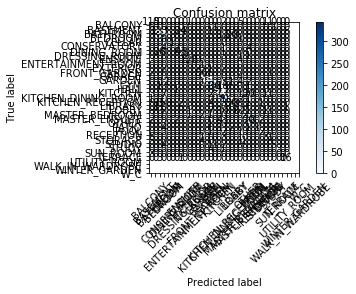

In [42]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect cats


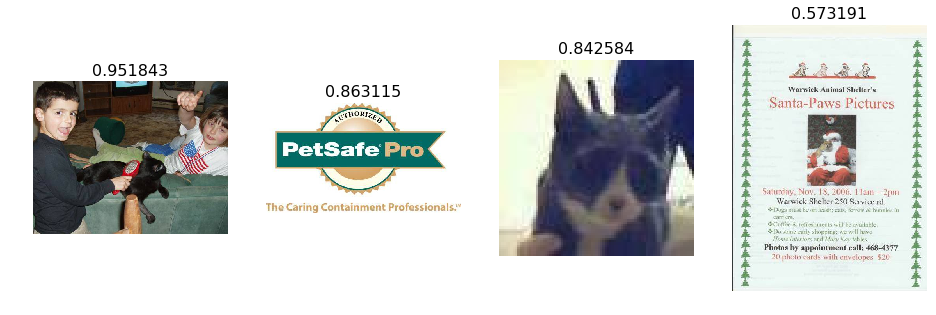

In [38]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


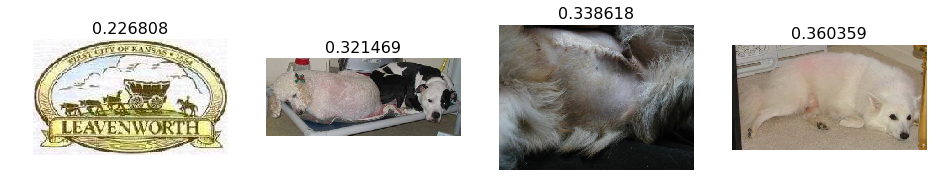

In [39]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

Let's look at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

In [29]:
tfms = tfms_from_model(resnet34, sz)

We need a <b>path</b> that points to the dataset. In this path we will also store temporary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [30]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds *learner* that contains a pre-trained model. The last layer of the model needs to be replaced with the layer of the right dimensions. The pretained model was trained for 1000 classes therfore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a two dimensional vector. The diagram below shows in an example how this was done in one of the earliest successful CNNs. The layer "FC8" here would get replaced with a new layer with 2 outputs.

<img src="images/pretrained.png" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [31]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters*  are learned by fitting a model to the data. *Hyperparameters* are another kind of parameter, that cannot be directly learned from the regular training process. These parameters express “higher-level” properties of the model such as its complexity or how fast it should learn. Two examples of hyperparameters are the *learning rate* and the *number of epochs*.

During iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iteration of Stochastic Gradient Descent (SGD). An *epoch* is a single pass through the entire training set which consists of multiple iterations of SGD.

We can now *fit* the model; that is, use *gradient descent* to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass two hyperameters: the *learning rate* (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well.)

In [32]:
learn.fit(1e-2, 1)

A Jupyter Widget

[ 0.       0.04153  0.02681  0.98877]                          



## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [34]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [35]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.